# FPGheArt - Week 3 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653




In [1]:
import numpy as np
import random
import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import initializers, regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
np.random.seed(2021)
tf.random.set_seed(3)
random.seed(19)

### Useful function

In [4]:
def plot_res(fit1):
    '''
    Simple function to plot the history of train and validation accuracy
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # summarize history for loss
    ax1.plot(fit1.history['loss'], label = "Train Loss", color = '#648FFF', lw = 2.5)
    ax1.plot(fit1.history['val_loss'], label = "Validation Loss", color = '#FE6100', lw = 2.5)
    ax1.legend()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Model Loss')
    ax1.grid(ls = '--')

    # summarize history for accuracy
    ax2.plot(fit1.history['accuracy'], label = 'Train Accuracy', color =  '#648FFF', lw = 2.5)
    ax2.plot(fit1.history['val_accuracy'], label = 'Validation Accuracy', color = '#FE6100', lw = 2.5)
    ax2.legend()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Model Accuracy')
    ax2.grid(ls = '--')

    plt.show()

In [5]:
def plot_acc(fit, label_fit, colors = ['blue', 'red', 'green']):
    """
    Simple function to compare the learning curve of various model
    """
    fig, ax = plt.subplots(figsize = (10, 7))
    for i in range(len(fit)):
        ax.plot(fit[i].history['accuracy'], label = (label_fit[i] + ' Train Accuracy'), lw = 2.5, ls = ':', color = colors[i])
        ax.plot(fit[i].history['val_accuracy'], label = (label_fit[i] + ' Validation Accuracy'), lw = 2.5, color = colors[i])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Model Accuracy')
    ax.grid(ls = '--')
    ax.legend()
    plt.show()

In [6]:
def plot_conf_mat(c_matrix, ax, title = ''):
    """
    Simple function that plot the confusion matrix
    """
    ax.imshow(c_matrix, cmap = plt.cm.YlGn, alpha = 0.5, vmin = 0, vmax = 1)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    for i in range(3):
        for j in range(3):
            ax.text(x=j, y=i, s=round(c_matrix[i, j],2), ha="center", va="center")
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    fig.tight_layout()

In [7]:
def create_CNN(reg, lam, fil, k_size, dense, Poolsize, bias_reg, act_reg):
    """
    This function allow to define a CNN given its parameters
    """
    ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

    model = Sequential()
    if bias_reg == True:        
        model.add(Conv1D(filters = fil[0], kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            bias_regularizer = reg(lam),
                            bias_initializer = ini,
                            activation = "relu",
                            input_shape = input_shape
                            ))
    elif act_reg == True:    
        model.add(Conv1D(filters = fil[0], kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            activity_regularizer = reg(lam),
                            activation = "relu",
                            input_shape = input_shape
                            ))
    else:     
        model.add(Conv1D(filters = fil[0], kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            activation = "relu",
                            input_shape = input_shape
                            ))
        
    model.add(MaxPooling1D(Poolsize))
    for i in range(1,len(fil)):
        model.add(Conv1D(filters = fil[i], kernel_size = k_size[i], activation = "relu"))
        #model.add(MaxPooling1D(Poolsize))
    model.add(Flatten())
    for i in range(len(dense)):
        model.add(Dense(dense[i],activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ, activation="softmax"))
    return model

In [8]:
def compile_model(reg = regularizers.l2, lam = 0.001, fil = [5,5], 
                  k_size = [11,7], dense = [10], Poolsize = 5, bias_reg = False, act_reg = False):
    # create the mode
    model=create_CNN(reg, lam, fil, k_size, dense, Poolsize, bias_reg, act_reg)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer = "adam", metrics = ["accuracy"])
    return model

# Ex 1

## Data 

In [9]:
str0 = "ts_L60_Z12_A500.0_DX50_bias5_N10000"

fnamex = "DATA/x_"+str0+".csv"
fnamey = "DATA/y_"+str0+".csv"

x = np.asarray(pd.read_csv(fnamex, header = None))
N = len(x)

In [10]:
categ  = np.asarray(pd.read_csv(fnamey, header = None), dtype = int)
y = to_categorical(categ)

In [11]:
L = len(x[0])
input_shape = (len(x[0]),1)
N_categ = 3

## Data splitting

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True)
x_train = x_train.reshape(x_train.shape[0],L,1)
x_test = x_test.reshape(x_test.shape[0],L,1)

## CNN definition

In [13]:
model = compile_model()
model.save_weights('Original_Weights_CNN1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 5)             60        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

The model previously defined is trained using the original data (NOT standardized).

In [14]:
hist = model.fit(x_train, y_train, batch_size = 250, epochs = 250, 
                 validation_data = (x_test, y_test), 
                verbose = 0, shuffle = True)

In [15]:
print(f"Validation accuracy is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}")

Validation accuracy is 0.32


As we expected the error does not decrease during the trainig procedure, this is due to the fact that the NN has as input larger numbers. To have decent results, standardized data are used, avoiding gradient vanishing during training.

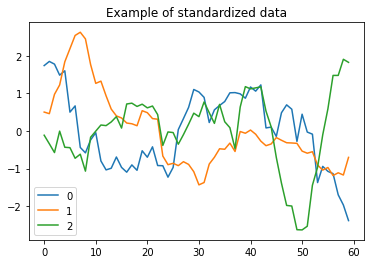

In [16]:
#Standardized data are computed
scaler = StandardScaler()
x_std =  scaler.fit_transform(x.T).T

plt.plot(x_std[0], label = '0')
plt.plot(x_std[1], label = '1')
plt.plot(x_std[2], label = '2')
plt.title('Example of standardized data')
plt.legend()
plt.show() 

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2) #using standardized data
x_train = x_train.reshape(x_train.shape[0],L,1)
x_test = x_test.reshape(x_test.shape[0],L,1)

In [18]:
model = compile_model()
hist = model.fit(x_train, y_train, batch_size = 250, epochs = 300, 
                 validation_data = (x_test, y_test), 
                verbose = 0, shuffle = True)

In [19]:
print(f"Validation accuracy is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}")

Validation accuracy is 0.81


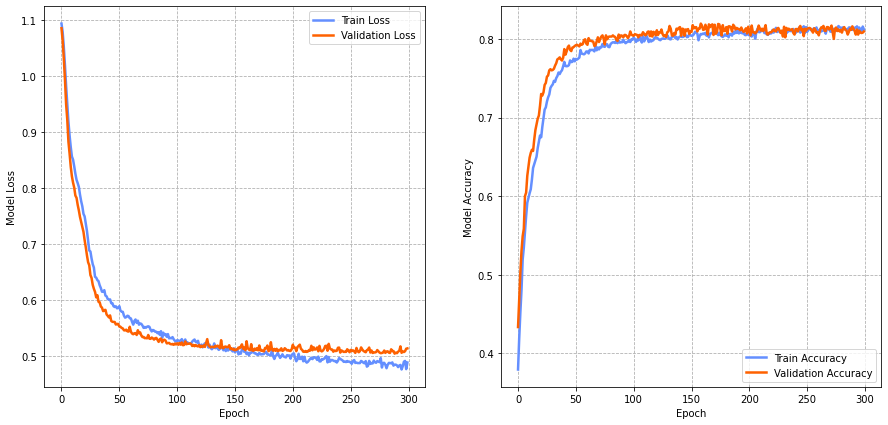

In [20]:
plot_res(hist)

After stadardization the model is working fine.

## Confusion Matrix

A confusion matrix helps to visualize the performance of the CNN in the classification task

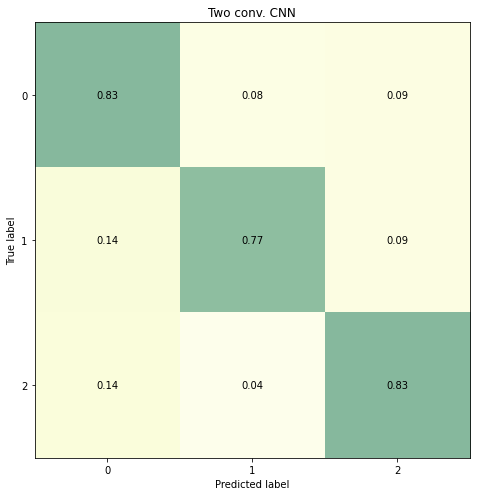

In [21]:
c_matrix = confusion_matrix(np.argmax(y_test, axis =1),np.argmax(model.predict(x_test), axis=1),  normalize = 'true')
fig, ax1 = plt.subplots(figsize = (7,7))
plot_conf_mat(c_matrix, ax1, 'Two conv. CNN')
plt.show()

For each class the 80% ca. of the data are correctly classified.

## Signal-to-noise ratio performances dependance

In this section the performance of the network are tested reducing the signal-to-noise ratio. Different datasets are produced using different parameters A (amplitude of external signal) and are fed in the network. Confusion matrices are displayed in order to better visualize the results.

In [22]:
As = np.linspace(50,500,10)
res = []
y_predicted_list = []
y_list = []

for A in As:
    str0 = f"ts_L60_Z12_A{A}_DX50_bias5_N10000"
    fnamex = "DATA/x_" + str0 + ".csv"
    fnamey = "DATA/y_" + str0 + ".csv"

    x = np.asarray(pd.read_csv(fnamex, header = None))

    x_std =  scaler.fit_transform(x.T).T

    categ  = np.asarray(pd.read_csv(fnamey, header = None), dtype = int)
    
    y = to_categorical(categ)

    x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2)
    x_train = x_train.reshape(x_train.shape[0],L,1)
    x_test = x_test.reshape(x_test.shape[0],L,1)
    
    model.load_weights("Original_Weights_CNN1.h5")  #We load the original weights to restart every time the fit
    
    hist = model.fit(x_train, y_train, batch_size = 250, epochs = 150, 
                 validation_data = (x_test, y_test), 
                verbose = 0, shuffle = True)
    res.append(pd.DataFrame(hist.history).iloc[:,-1])
    y_list.append(np.argmax(y_test, axis = 1))
    y_predicted_list.append(np.argmax(model.predict(x_test), axis = 1))

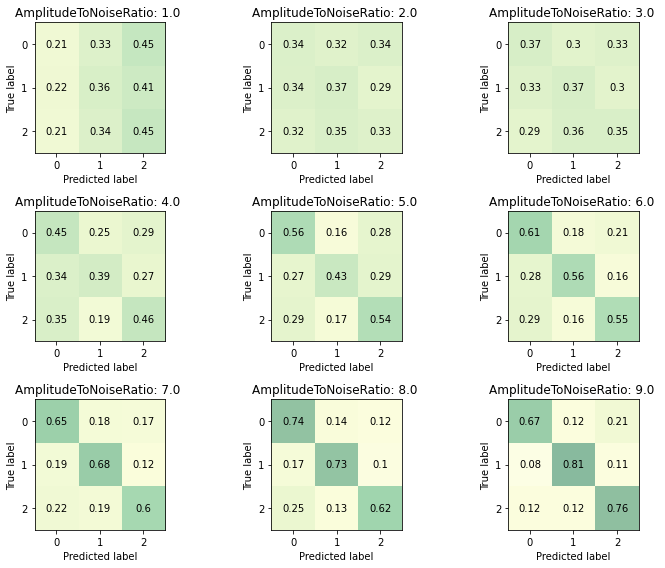

In [23]:
fig, ax1 = plt.subplots(nrows=3, ncols=3, figsize = (15, 8))

for i in range(3):
    for j in range(3):
        c_matrix = confusion_matrix(y_list[3*i+j],y_predicted_list[3*i+j],  normalize = 'true')
        plot_conf_mat(c_matrix, ax1[i, j], f"AmplitudeToNoiseRatio: {As[3*i+j]/50} ")
        fig.tight_layout()
plt.show()

As expected, from the confusion matrices is easy to see that for data with a small signal-to-noise ratio the network classifies wrongly more samples. The bigger the amplitude the better are the results.

# Ex 2

In this chapter three different networks, using a single convolution layer, are considered. Performances will be, in general, slightly worse with respect to the network trained with two convoultional layers (less parameters are used).

In [24]:
np.random.seed(12)
tf.random.set_seed(13)
random.seed(23)

## Data

In [25]:
x = np.loadtxt("DATA/x_ts_comp_N10000.csv", delimiter =",")
categ_y = np.loadtxt("DATA/y_ts_comp_N10000.csv", delimiter =",")

scaler = StandardScaler()
x =  scaler.fit_transform(x.T).T

In [26]:
y = to_categorical(categ_y)

In [27]:
L = len(x[0])
input_shape = (len(x[0]),1)
N_categ = 3

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True)
x_train = x_train.reshape(x_train.shape[0],L,1)
x_test = x_test.reshape(x_test.shape[0],L,1)

## First model

#### _1 conv layer (4 filters, kernel_size = 10), 2 dense layers (10 neurons)_

In [29]:
model = compile_model(fil = [4], k_size = [10], dense = [10,10], lam = 0.001, Poolsize = 5)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 51, 4)             44        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 4)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [30]:
batch_size = 250
epochs = 250
fit1 = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

In [31]:
print(f"Validation accuracy is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}")

Validation accuracy is 0.7


## Second model

#### _1 conv. layer (3 filters, kernel_size = 5), 1 dense layer (12 neurons)_

In [32]:
model = compile_model(fil = [3], k_size = [5], Poolsize = 5, dense = [12], lam = 0.001)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 56, 3)             18        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 11, 3)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 33)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                408       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 39        
Total params: 465
Trainable params: 465
Non-trainable params: 0
________________________________________________________

In [33]:
batch_size = 250
epochs = 250
fit2 = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

In [34]:
print(f"Validation accuracy is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}")

Validation accuracy is 0.64


## Third model

#### _1 conv. layer (13 filters, kernel_size 23),  1 dense layer (3 neurons)_

In [35]:
model = compile_model(fil = [13], k_size = [23], Poolsize = 5, dense = [3], lam = 0.001)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 38, 13)            312       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 13)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 91)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 276       
_________________________________________________________________
dropout_4 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 12        
Total params: 600
Trainable params: 600
Non-trainable params: 0
________________________________________________________

In [36]:
batch_size = 250
epochs = 250

fit3 = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

In [37]:
print(f"Validation accuracy is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}")

Validation accuracy is 0.74


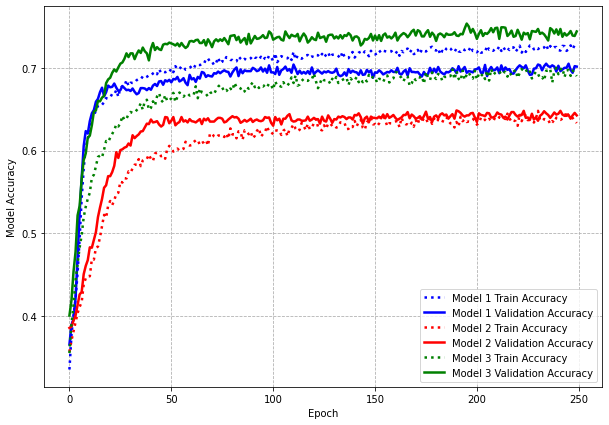

In [38]:
label_fit = ['Model 1', 'Model 2', 'Model 3']
fit_n = [fit1, fit2, fit3]
plot_acc(fit_n, label_fit)

The three models show similar results. The second model seems to be worse that the others, probabliy this is due to the fact that it has less parameters. Strangely, in the third model the validation accuracy is higher than the training one. 

Nevertheless we can appreciate how, in general, adding a dense layer increases consistently the number of parameters with respect to a convolutional layer; this is due to the fully connected structure of the first one. Note that this is not a rule, in fact the number of weights strongly depends on the dimensions of such layers. For example a Conv. layer with an high number of filters bring a huge number of parameters.

# Regularization

Regularization effects on the model performace are studied for the model used in lesson through a grid search.

In [39]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# define parameter dictionary
reg = [regularizers.l1, regularizers.l2, regularizers.l1_l2]
lam = [0.1,0.01,0.001,0.0001]
param_grid = dict(reg = reg , lam = lam)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid.fit(x_train,y_train, epochs=250, batch_size = 250, shuffle = True, verbose = 0)

63/63 [==============================] - 0s 887us/step - loss: 0.6625 - accuracy: 0.6860


GridSearchCV(cv=4,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f184c5977f0>,
             n_jobs=1,
             param_grid={'lam': [0.1, 0.01, 0.001, 0.0001],
                         'reg': [<class 'tensorflow.python.keras.regularizers.L1'>,
                                 <class 'tensorflow.python.keras.regularizers.L2'>,
                                 <function l1_l2 at 0x7f18b4b5f550>]})

In [40]:
df_GridSearch = pd.DataFrame(grid.cv_results_)
df_GridSearch = df_GridSearch.iloc[:,1:]
df_GridSearch.sort_values(by = "rank_test_score", ascending = False)

,std_fit_time,mean_score_time,std_score_time,param_lam,param_reg,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.944258,0.165795,0.024416,0.1,<class 'tensorflow.python.keras.regularizers.L1'>,"{'lam': 0.1, 'reg': <class 'tensorflow.python....",0.3345,0.3310,0.3330,0.3250,0.330875,0.003612,12
2,2.934808,0.158063,0.020382,0.1,<function l1_l2 at 0x7f18b4b5f550>,"{'lam': 0.1, 'reg': <function l1_l2 at 0x7f18b...",0.3345,0.3310,0.6660,0.3250,0.414125,0.145460,11
3,0.900677,0.144814,0.020939,0.01,<class 'tensorflow.python.keras.regularizers.L1'>,"{'lam': 0.01, 'reg': <class 'tensorflow.python...",0.6975,0.7325,0.7090,0.6815,0.705125,0.018579,10
1,1.869324,0.128318,0.001873,0.1,<class 'tensorflow.python.keras.regularizers.L2'>,"{'lam': 0.1, 'reg': <class 'tensorflow.python....",0.7230,0.6605,0.7510,0.7060,0.710125,0.032849,9
9,0.226498,0.140228,0.007306,0.0001,<class 'tensorflow.python.keras.regularizers.L1'>,"{'lam': 0.0001, 'reg': <class 'tensorflow.pyth...",0.7175,0.6930,0.7395,0.7125,0.715625,0.016547,8
5,3.201203,0.159630,0.019757,0.01,<function l1_l2 at 0x7f18b4b5f550>,"{'lam': 0.01, 'reg': <function l1_l2 at 0x7f18...",0.7315,0.7235,0.7460,0.6730,0.718500,0.027480,7
7,3.343786,0.145738,0.018978,0.001,<class 'tensorflow.python.keras.regularizers.L2'>,"{'lam': 0.001, 'reg': <class 'tensorflow.pytho...",0.7480,0.7110,0.7185,0.7045,0.720500,0.016632,6
6,0.928499,0.147562,0.021036,0.001,<class 'tensorflow.python.keras.regularizers.L1'>,"{'lam': 0.001, 'reg': <class 'tensorflow.pytho...",0.7600,0.7125,0.6975,0.7175,0.721875,0.023209,5
11,3.237116,0.163607,0.019176,0.0001,<function l1_l2 at 0x7f18b4b5f550>,"{'lam': 0.0001, 'reg': <function l1_l2 at 0x7f...",0.7090,0.7585,0.7470,0.6860,0.725125,0.029083,4
10,2.930029,0.157225,0.023816,0.0001,<class 'tensorflow.python.keras.regularizers.L2'>,"{'lam': 0.0001, 'reg': <class 'tensorflow.pyth...",0.7110,0.7380,0.7235,0.7325,0.726250,0.010213,3


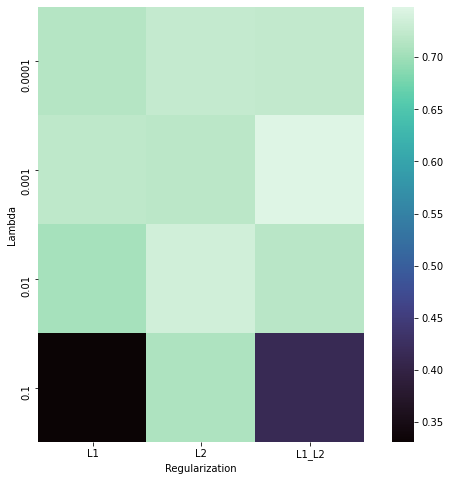

In [41]:
fig = plt.figure(figsize= (10,8))
pr = df_GridSearch.pivot(index = "param_lam", columns = "param_reg", values = "mean_test_score")
g = sns.heatmap(pr, cmap="mako", square = True)
g.set(xticklabels=["L1", "L2", "L1_L2"])
plt.xticks(rotation=0)
plt.xlabel('Regularization')
plt.ylabel('Lambda')
plt.show()

Best fits are achieved by regularizers with small parameters: L2 perform better with lambda = 0.01 while L1 and L1_L2  brings similar results with a parameter=0.001. Definitely using a too strong regularization (L1 with 0.1 for example) gives poorer results. 

Let us now visualize the final weights of one convolutional layers (ex the first one), after the fit procedure.

In [42]:
batch_size = 250
epochs = 250

model1 = compile_model(reg = regularizers.l2,  lam = 0.1,)
model2 = compile_model(reg = regularizers.l2,  lam = 0.001, )

model1.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)
model2.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

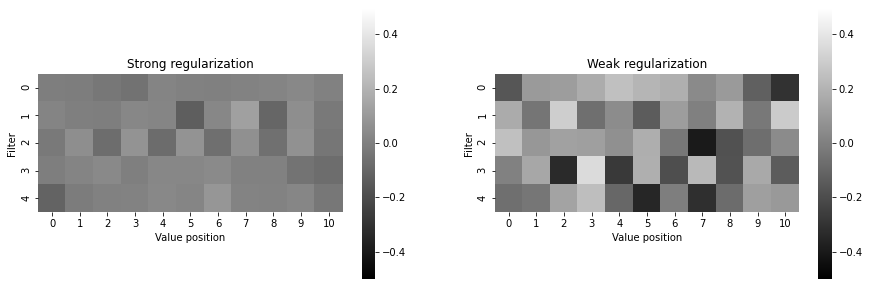

In [43]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

filters, biases = model1.layers[0].get_weights()
sns.heatmap(filters.reshape(11,5).T, ax = axes[0], cmap = "gray", vmin = -0.5, vmax = 0.5, square = True)
axes[0].set_title("Strong regularization")
axes[0].set_ylabel('Filter')
axes[0].set_xlabel('Value position')

filters, biases = model2.layers[0].get_weights()
sns.heatmap(filters.reshape(11,5).T, ax = axes[1], cmap = "gray", vmin = -0.5, vmax = 0.5, square = True)
axes[1].set_title("Weak regularization")
axes[1].set_ylabel('Filter')
axes[1].set_xlabel('Value position')

plt.show()

As expected, in the case of stronger regularization the final values of the weights are smaller compared to the one reached with a weaker regularization. Therefore a weaker regularization allows to see eventual patterns in the final parameters.  

In [44]:
results1 = model1.evaluate(x_test, y_test, verbose = 0)
results2 = model2.evaluate(x_test, y_test, verbose = 0)

print(f"Validation accuracy for strong regularization is {results1[1]:1.2}, while for weak regularization is {results2[1]:1.2}")

Validation accuracy for strong regularization is 0.73, while for weak regularization is 0.72


In the next cells weights coming from different type of regularization (L1 and L2) are compared.

In [45]:
model3 = compile_model(reg = regularizers.l1,  lam = 0.001)
model3.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

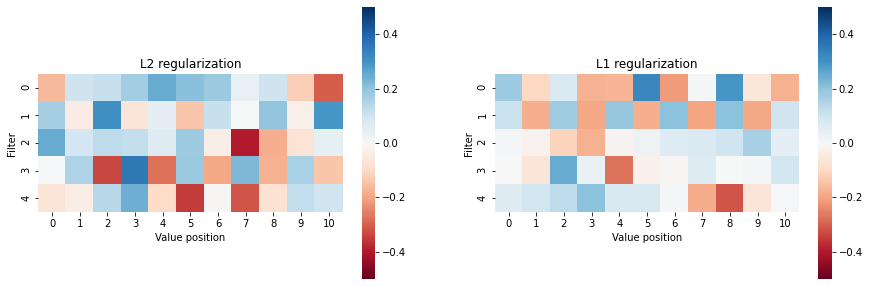

In [46]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

filters, biases = model2.layers[0].get_weights()
sns.heatmap(filters.reshape(11,5).T, ax = axes[0], cmap = "RdBu", vmin = -0.5, vmax = 0.5, square = True)
axes[0].set_title("L2 regularization")
axes[0].set_ylabel('Filter')
axes[0].set_xlabel('Value position')

filters, biases = model3.layers[0].get_weights()
sns.heatmap(filters.reshape(11,5).T, ax = axes[1], cmap = "RdBu", vmin = -0.5, vmax = 0.5, square = True)
axes[1].set_title("L1 regularization")
axes[1].set_ylabel('Filter')
axes[1].set_xlabel('Value position')

plt.show()

As expected one can see that the weights matrices coming from L1 regularization are more sparse, with more values that are almost zero. This is the typical effect of Lasso regularization.

## Bias Regularization

In [47]:
model = compile_model()
fit1 = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

In [48]:
print(f"Validation loss is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}. This is the reference result")

Validation loss is 0.75. This is the reference result


In [49]:
model = compile_model()
fit2 = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

In [50]:
print(f"Validation loss with bias regularization is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}")

Validation loss with bias regularization is 0.75


In [51]:
model = compile_model()
fit3 = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data = (x_test, y_test), shuffle = True, verbose = 0)

In [52]:
print(f"Validation accuracy with activity regularization is {model.evaluate(x_test, y_test, verbose = 0)[1]:1.2}")

Validation accuracy with activity regularization is 0.75


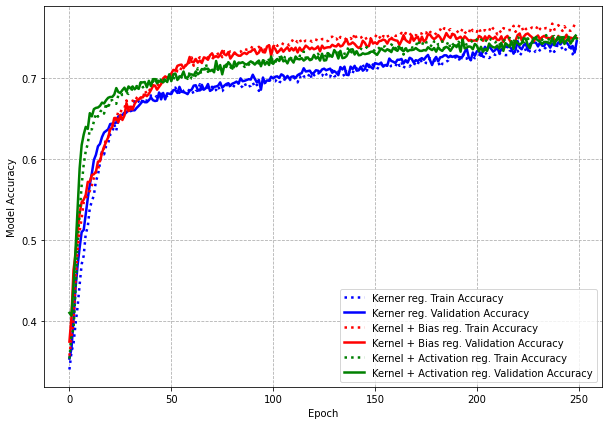

In [53]:
label_fit = ['Kerner reg.', 'Kernel + Bias reg.', 'Kernel + Activation reg.']
fit_n = [fit1, fit2, fit3]
plot_acc(fit_n, label_fit)

Different regularizations have similar performances, and their results slightly differs due to different initial parameters.

# Appendix: exercise 2 CNN application

In this section we repeat the analysis of the dataset used in the exercise of the second week using a CNN.

In [54]:
np.random.seed(12)
tf.random.set_seed(13)
random.seed(23)

## Data

In [55]:
fname="DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter=',',
                   usecols= (0,1), unpack=True, dtype = str)

In [56]:
N = len(sy)
print(f"Number of total samples {N}")
Ls = len(sx[0])
print(f"Lenght of a sample {Ls}")

print(f"Sample: {sx[0]}, label: {sy[0]}")

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N -N_train
print(f'\ndata:{N}\ntrain: {N_train}\ntest: {N_test}')

Number of total samples 3000
Lenght of a sample 16
Sample: AAGGTCTGCCGGCCGA, label: 1

data:3000
train: 2400
test: 600


In [57]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc = {Q[i]: i for i in range(Nc)}
print(f"One-hot encoding dictionary: {onehc}")

One-hot encoding dictionary: {'A': 0, 'C': 1, 'G': 2, 'T': 3}


## Data conversion: One-Hot Encoding

In [58]:
Y = sy.astype(int)

L = Ls*Nc
print(f"Product of lenght ({Ls}) and character possibilities ({Nc}): {L}\n")

X = np.zeros((N,L))

for n in range(N):
    for i in range(Ls):
        X[n][i*4 + onehc[sx[n][i]]] = 1
print(f"Original sequence:\n {sx[0]}\n")
print(f"Encoded sequence:\n {X[0]}")

Product of lenght (16) and character possibilities (4): 64

Original sequence:
 AAGGTCTGCCGGCCGA

Encoded sequence:
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


## Split train/test - validation

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = True)

print(f"Ratio between y_train labels sum and train samples: {Y_train.sum() / N_train}")
print(f"Ratio between y_test  labels sum and test samples: {Y_test.sum() / N_test}")

Ratio between y_train labels sum and train samples: 0.2554166666666667
Ratio between y_test  labels sum and test samples: 0.21


## Model

A CNN is designed and compared with the best NN obtainied in the __exercise 2__ .

In [60]:
model = keras.Sequential([
    # Block One
    keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same',
                  input_shape=[16,4]),
    keras.layers.MaxPool1D(),

    # Block Two
    keras.layers.Conv1D(filters=16, kernel_size=6, activation='relu', padding='same'),
    keras.layers.MaxPool1D(),

    # Head
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_117 (Conv1D)          (None, 16, 16)            208       
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 8, 16)             0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 8, 16)             1552      
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 4)                 260       
_________________________________________________________________
dropout_60 (Dropout)         (None, 4)               

In [62]:
new_X_train = X_train.reshape(2400, 16,4)
new_X_test = X_test.reshape(600,16,4)

In [63]:
batch_size = 250
epochs = 150
fit = model.fit(new_X_train, Y_train, batch_size = batch_size, epochs=epochs, validation_data = (new_X_test, Y_test), shuffle = True, verbose = 0)

In [64]:
model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

model.summary()

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

fit_best = model.fit(X_train, Y_train, epochs=150, batch_size = 50, validation_data = (X_test,Y_test), shuffle = True, verbose = 0)



Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_124 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_125 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_61 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


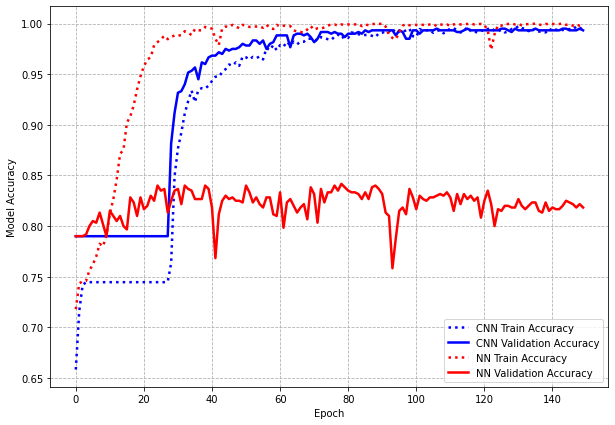

In [65]:
label_fit = ['CNN', 'NN']
fit_n = [fit, fit_best]
plot_acc(fit_n, label_fit)

For the analysed dataset a CNN with less than a third parameters than a normal NN manage to achieve much better results reguarding the validation accuracy.

The strange behaviour of the CNN at the beginning depends on the random seeds.